### Lab 3

In this lab, we will cover 3D geometry and camera projections. Complete all work inside this notebook file and submit only this file.

##### Introduction

In this first part, we will implement basic rasterization of a point cloud. Rasterization is the process of turning a 3D representation into a 2D image.

The process of rasterization can be defined by the folowing equation. 

![](image.png "Projection Matrix")

The projection matrix is used to convert from 3D read world coordinates to 2D image coordinates and is formed through the multiplication of the camera intrinsic matrix, which holds properties about the camera such as focal length and near and far plane, and the camera extrinsic matrix, which holds geometric properties of the camera such as rotation and translation.  

### Step 1: Defining the Extrinsic Matrix

The extrinsic matrix holds the transformation the points should take to transform from the world to the camera coordinate system. And can be defined as 

$$
[R|t] =
\begin{bmatrix}
r_{1,1} & r_{1,2} & r_{1,3} & t_1 \\
r_{2,1} & r_{2,2} & r_{2,3} & t_2 \\
r_{3,1} & r_{3,2} & r_{3,3} & t_3 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

where t is the translation and r is the 3x3 rotation matrix. The bottom row of [0,0,0,1] ensures that the extrinsic matrix is in the homogonous coordinate system. A more user-friendly way to represent the extrinsic matrix is by building it from the camera pose as opposed to from how world points should transform to camera coordinates. This is relatively easy to do, we can just take the inverse of the matrix that defines the camera pose. 

Our camera pose can be defined as two components, ${C}$ and ${R_c}$, the camera center is world space and the rotation matrix describes the camera's orientation in world space. Therefore the transformation matrix that represents the camera pose can be defined as 

$$
 [R_c|C] = \begin{bmatrix}
R_c & C  \\
0 & 1 \\
\end{bmatrix}
$$

and the extrinsic matrix ${[R|t]}$ from ${[R_c|C]}$ can be calculated by finding the inverse as follows, where T is the transpose:

$$
\begin{bmatrix}
R & t  \\
0 & 1 \\
\end{bmatrix}  =
\begin{bmatrix}
R_c & C  \\
0 & 1 \\
\end{bmatrix} ^{-1}
=
\begin{bmatrix}
R_c^T & -R_c^T C  \\
0 & 1 \\
\end{bmatrix}
$$

A more detailed guide on this process can be found here: https://ksimek.github.io/2012/08/22/extrinsic/

##### Task: Provided are the camera centre ${C}$ and the rotation matrix ${R_c}$. Following the equation above calculate ${[R|t]}$ and print the matrix.


In [2]:
import numpy as np
import open3d as o3d

R_c = np.array([[-1, 0, 0],
                [0, -1, 0],
                [0, 0, 1]]) # Camera rotation

C = np.array([2.26234174, 1.62975371, 5.0])  # Camera position

# Calculate the extrinsic matrix [R|t]
R = R_c.transpose()
t = (-R @ C).reshape(-1, 1)

R_transpose_C = np.hstack((R, t))

R_cols = R.shape[1]
t_cols = t.shape[1]

r4 = np.concatenate((np.zeros(R_cols), np.ones(t_cols)))

extrinsic = np.vstack((R_transpose_C, r4))

print(extrinsic)

[[-1.          0.          0.          2.26234174]
 [ 0.         -1.          0.          1.62975371]
 [ 0.          0.          1.         -5.        ]
 [ 0.          0.          0.          1.        ]]


### Step 2: Defining the Intrinsic matrix

The intrinsic matrix is far easier to define and is parameterised by the focal length ${f}$, the principle point offset ${x}$ and the skew ${s}$.

$$
k = 
\begin{bmatrix}
f_x & s & x_0 \\
0 & f_y & y_0 \\
0 & 0 & 1\\
\end{bmatrix}
$$

##### Task: Provided are the values for the focal length, principle point offset and skew. Define and print the intrinsic matrix

In [3]:
fx = 800
fy = 800
ppx = 400
ppy = 400
s = 0

#Solution 
k = np.array([
    [fx, s, ppx], 
    [0, fy, ppy], 
    [0, 0, 1]
])

print(k)


[[800   0 400]
 [  0 800 400]
 [  0   0   1]]


### Step 3: Forming the projection matrix

The projection matrix is calculated by multiplying the intrinsic matrix with the extrinsic matrix, defined as

$$
P = K [R|t]
$$

##### Task: Calculate and print the projection matrix using the previously calculated intrinsic and extrinsic matrices

In [4]:
# Calculate the projection matrix P

projection = k @ extrinsic[:3, :]
projection


array([[-800.      ,    0.      ,  400.      , -190.126608],
       [   0.      , -800.      ,  400.      , -696.197032],
       [   0.      ,    0.      ,    1.      ,   -5.      ]])

### Step 4: Loading our data

As stated above we want to render a point cloud. To load in the point cloud we will use the python package open3D. You can read more about the structure of the PointCloud object here: https://www.open3d.org/html/python_api/open3d.geometry.PointCloud.html. *Print out the first 10 points from the point cloud and the corresponding color values.*


In [5]:
# Load the point cloud
point_cloud = o3d.io.read_point_cloud("fragment.ply")

# Print the first 10 points
points = np.asarray(point_cloud.points[:10])
print(points)

# print the first 10 colors
colors = np.asarray(point_cloud.colors[:10])
print(colors)

[[0.65234375 0.84686458 2.37890625]
 [0.65234375 0.83984375 2.38430572]
 [0.66737998 0.83984375 2.37890625]
 [0.66015625 0.84661984 2.37890625]
 [0.66015625 0.83984375 2.38411689]
 [0.67578125 0.83984375 2.38014007]
 [0.63671875 0.83203125 2.40091062]
 [0.64453125 0.83203125 2.39635015]
 [0.65459806 0.83203125 2.39453125]
 [0.65234375 0.83427423 2.39453125]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


### Step 5: Project the point cloud

In this step, we will project the point cloud onto the image plane using the projection matrix we have defined above. Apply the transformation matrix to the point cloud data and print out the first 10 projected points (the uv coordinates, see fig 1).

To do this you will first need to convert the points to homogeneous coordinates like so [x,y,z,1]. You will then need to apply the projection matrix. Finally you will need to normalize the projected points by the third coordinate, like `projected_point /= projected_point[2]` to get 2D image coordinates.

In [9]:
# Get the points from the point cloud
points = np.asarray(point_cloud.points)
points.shape

# Convert points to homogeneous coordinates
points_h = np.hstack((points, np.ones((points.shape[0], 1))))

# Apply the projection matrix
points_projected = (projection @ points_h.T).T

# Normalize by the third coordinate to get 2D image coordinates
points_projected[:, 0] /= points_projected[:, 2]
points_projected[:, 1] /= points_projected[:, 2]
points_projected[:, 2] /= points_projected[:, 2]

# Print the first 10 projected points
print(points_projected[:, :10])


[[-91.39730008 161.04963696   1.        ]
 [-92.41167045 158.40908788   1.        ]
 [-86.8080021  158.90676631   1.        ]
 ...
 [334.74601965 596.52000024   1.        ]
 [333.59148262 596.61091735   1.        ]
 [333.56556881 596.59668592   1.        ]]


### Step 6: Rasterize the points onto the image array

We will rasterize the points onto an image plane of size 800 by 800. To do this we will first define an image buffer of shape 800x800x3. We will then iterate through each of the points, determine if it falls on the image plane (ie x <= 0 < image_width) and if so update the image buffer with the colour value of the point.

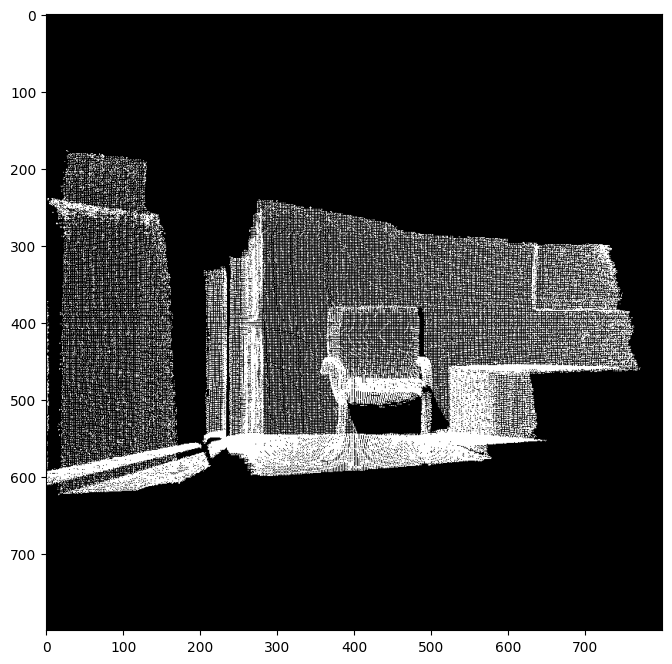

In [ ]:
import matplotlib.pyplot as plt

# Define the image size
width = 800
height = 800

# Create an empty image array
image = np.zeros((height, width, 3), dtype=np.uint8)

# Filter out points with invalid coordinates
valid_coordinates = []
for point in points_projected:
    if point[0] >= 0 and point[0] < width and point[1] >= 0 and point[1] < height:
        valid_coordinates.append(point)

for point in valid_coordinates:
    x, y = int(point[0]), int(point[1])

    if len(point) == 5:
        r, g, b = point[2], point[3], point[4]
    else:
        r, g, b = 255, 255, 255

    image[y, x] = [r, g, b]


# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()


### Step 7: Define a new camera centre and rotation matrix to render a top-down view of the scene.

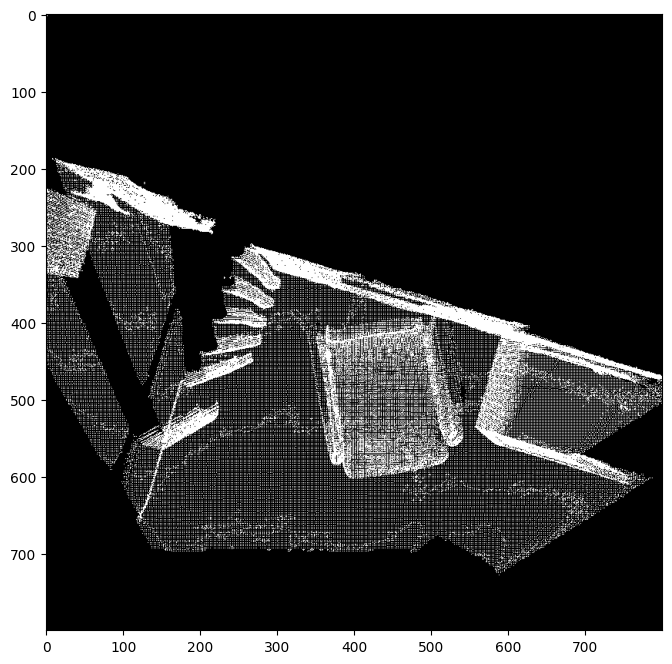

In [ ]:
## Solution
C = np.array([2.26234174, 5.0, 1.62975371])  # Camera position

R_c_top = np.array([
    [-1, 0, 0],
    [0, 0, 1],
    [0, 1, 0]
])

R = R_c_top.transpose()
t = (-R @ C).reshape(-1, 1)

R_transpose_C = np.hstack((R, t))

R_cols = R.shape[1]
t_cols = t.shape[1]

r4 = np.concatenate((np.zeros(R_cols), np.ones(t_cols)))

extrinsic = np.vstack((R_transpose_C, r4))

projection_top = k @ extrinsic[:3, :]

projected_top = (projection_top @ points_h.T).T
projected_top[:, 0] /= projected_top[:, 2]
projected_top[:, 1] /= projected_top[:, 2]
projected_top[:, 2] /= projected_top[:, 2]


image_top = np.zeros((height, width, 3), dtype=np.uint8)

# Filter out points with invalid coordinates
valid_coordinates = []
for point in projected_top:
    if point[0] >= 0 and point[0] < width and point[1] >= 0 and point[1] < height:
        valid_coordinates.append(point)

for point in valid_coordinates:
    x, y = int(point[0]), int(point[1])

    if len(point) == 5:
        r, g, b = point[2], point[3], point[4]
    else:
        r, g, b = 255, 255, 255

    image[y, x] = [r, g, b]

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()


## Questions
#### Q1: What happens in the algorithm described above if two points are stacked on top of each other? What changes could be made to the algorithm to address these issues?


When two points are stacked on top of each other, the points project to the same pixel, hence the later point overwrites the first. To fix this, a depth buffer can be used. This essentially maintains a 2D array storing the depth of the closees point rendered at each pixel. Before projecting a new point to a pixel, compare its depth to the stored value and only overwit it if it is closer to the camera

#### Q2: What changes would you make to the algorithm to scale the points?

To scale the points, a 4 x 4 scaling matrix with the scale factors sx, sy, and sz along the diagonal can be multiplied with the extrinsic matrix. 

#### Q3: What would be the effect of increasing/decreasing the fx and fy values? 

Increasing the fx and fy values zooms into the scene essentially causing a narrower field of view, thus making objects appear larger and covering less of the scene. Conversely, decreasing fx and fy zooms out causing a wider field of view, thus making objects appear smaller but showing more of the scene. 